# Notebook 2: Analyzing phenotypic nonlinearity in synthetic data

## Initiating workspace and loading data

<font size="3"> Set working directory

In [3]:
library(here)
here::here() # Should be set to the root of the repository
setwd(here::here())

here() starts at /Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes



[1] "/Users/ryanyork/Documents/Research/github/accounting-for-nonlinear-phenotypes"

<font size="3"> Source functions

In [4]:
suppressPackageStartupMessages(source('01_code/R/nonlinear_phenotype_utils.R'))

<font size="3"> Load synthetic phenotype data

In [5]:
phens <- pd$read_pickle("data/phen_pleio_int_01_0_1.pk")

<font size="3"> Combine phenotype vectors into matrices

In [6]:
# Combine phenotypes into matrices
phenos <- list()

# Generate naming vectors
p_pleio <- paste(rep("pleio", length(seq(0, 1, 0.01))), seq(0, 1, 0.01), sep = "")
p_int <- paste(rep("int", length(seq(0, 1, 0.01))), seq(0, 1, 0.01), sep = "")

# Combine phenotypes into matrices
for (i in 1:length(phens)) {
  for (j in 1:length(phens[[i]])) {
    phenos[[paste(p_pleio[i], p_int[j], sep = "_")]] <- do.call(cbind, phens[[i]][[j]])
  }
}

## Calculating and comparing entropy

<font size="3"> Calculate entropy by data fraction

In [7]:
# Split phenotype data as a function of interaction probability
p <- split(phenos, p_int)

# Calculate subsampled entropy for each probability
all_entropies <- list()

#Counter 
pb <- txtProgressBar(min = 1,
                     max = length(p$int0),
                     style = 3,
                     width = 50,
                     char = ".")

for (i in 1:length(p$int0)) {
  setTxtProgressBar(pb, i)
  all_entropies[[names(p$int0)[i]]] <- subsample.entropy(p$int0[[i]],
    numBins = 100,
    permutations = 1000,
    normalize_entropy = FALSE,
    sample_sizes = seq(0.1, 0.9, 0.05)
  )
}

  |....................................              |  71%

<font size="3"> Plot the distribution of entropy as a function of sample size

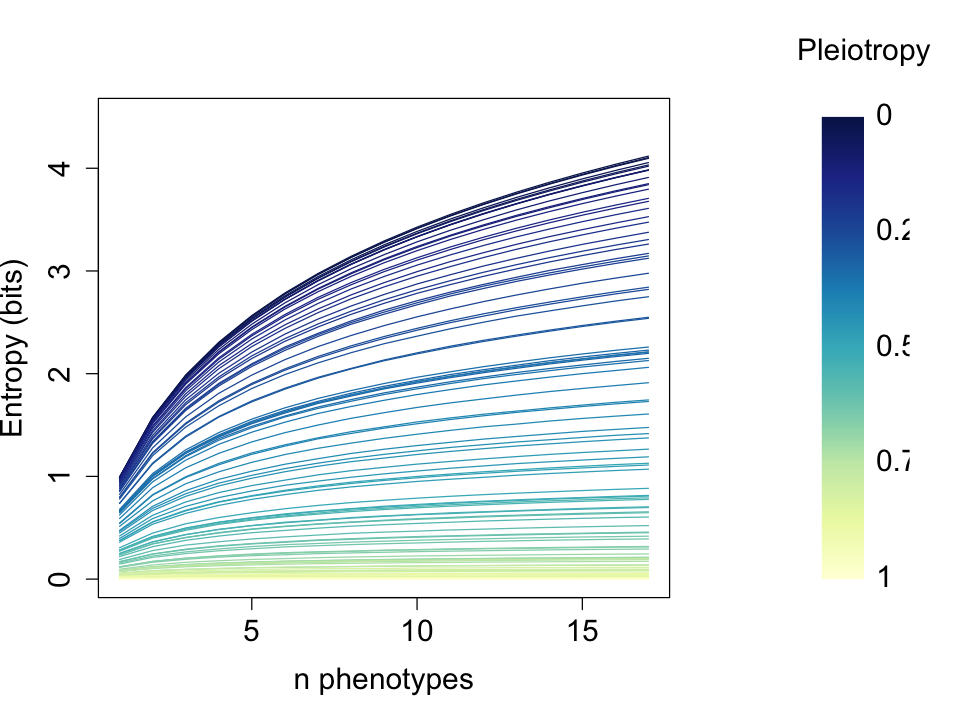

In [6]:
# Set up plot
options(repr.plot.width=8, repr.plot.height=6)
layout(matrix(1:2, ncol = 2), width = c(2, 1), height = c(1, 1))

# Set colors
cols <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(length(all_entropies)))

# Plot
plot(colMeans(do.call(cbind, all_entropies[[1]]$entropies)),
  type = "l",
  ylim = c(0, 4.5),
  col = cols[1],
  ylab = "Entropy (bits)",
  xlab = "n phenotypes",
  cex.axis = 1.5,
  cex.lab = 1.5
)
for (i in 2:length(all_entropies)) {
  lines(colMeans(do.call(cbind, all_entropies[[i]]$entropies)), col = cols[i])
}

# Add legend
legend_image <- as.raster(matrix(cols, ncol = 1))
plot(c(0, 2), c(0, 1), type = "n", axes = F, xlab = "", ylab = "", main = "Pleiotropy", font.main = 1)
text(x = 1.5, y = rev(seq(0, 1, l = 5)), labels = seq(0, 1, l = 5), pos = 1)
rasterImage(legend_image, 0, 0, 1, 1)

<font size="3"> Calculate the slope of the entropy distribution for each pleiotropy probability

In [7]:
slopes <- c()
for (i in 1:length(all_entropies)) {
  y <- colMeans(do.call(cbind, all_entropies[[i]]$entropies))
  slopes <- c(slopes, coef(lm(y ~ seq(1, length(y), 1)))[2])
}

<font size="3"> Plot

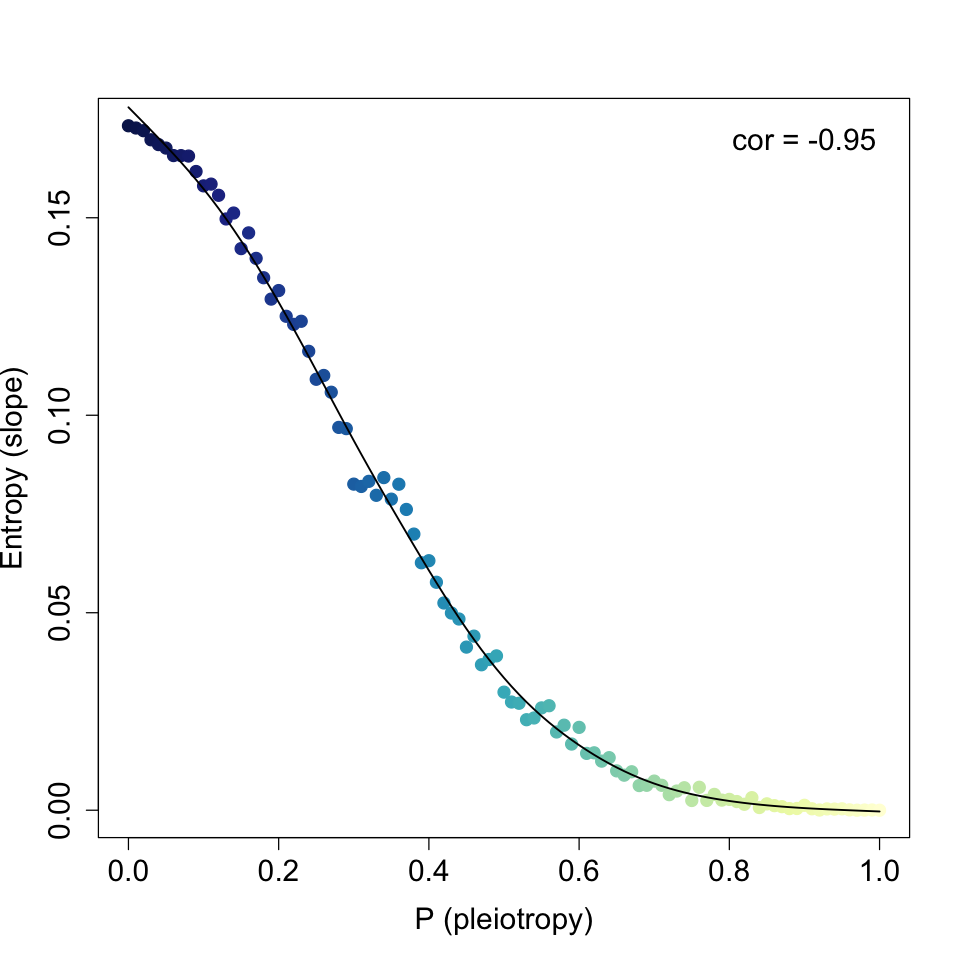

In [8]:
# Set up plot
options(repr.plot.width=8, repr.plot.height=8)

# Fit slopes and pleiotropy probability with a spline
a <- smooth.spline(seq(0, 1, 0.01),
  slopes,
  spar = 0.75
)$y

# Plot
plot(seq(0, 1, 0.01),
     slopes,
     pch = 20,
     cex = 2,
     col = cols,
     cex.axis = 1.5,
     cex.lab = 1.5,
     xlab = 'P (pleiotropy)',
     ylab = 'Entropy (slope)')
lines(seq(0, 1, 0.01), a, lwd = 1.5)
text(0.9, 
     0.17, 
     paste('cor =', round(cor(seq(0, 1, 0.01), slopes), 2)),
     cex = 1.5)

## Compare nonlinearity across probabilities

<font size="3"> Calculate nonlinearity for all combinations of pleiotropy and gene interaction probability

In [38]:
#Run function on all experiments
res <- list()
for (i in 1:length(phenos)) {
  print(paste(i, "out of", length(phenos)))
  res[[as.character(i)]] <- compare_nonlinear(phenos[[i]], verbose = TRUE, return_models = TRUE)

  a <- unlist(lapply(res[[as.character(i)]]$models, function(x) abs(x$AIC[2, 2]) - abs(x$AIC[1, 2])))
  print(sum(a < 0) / length(a))
}

[1] "1 out of 10201"
  |..................................................| 100%[1] 0.3825858
[1] "2 out of 10201"
  |..................................................| 100%[1] 0.3957784
[1] "3 out of 10201"
  |..................................................| 100%[1] 0.4063325
[1] "4 out of 10201"
  |......                                            |  12%

In [9]:
res <- readRDS('~/Desktop/nonlinear_phenotype_review/01_output/synthetic_data_nonlinear_models.RDS')

<font size="3"> Calculate AIC differences

In [10]:
# Calculate AIC differences
a <- c()
for (i in 1:length(res)) {
  tmp <- unlist(lapply(res[[i]]$models, function(x) abs(x$AIC[2, 2]) - abs(x$AIC[1, 2])))
  a <- c(a, sum(tmp < 0) / length(tmp))
}

# Split
a <- split(a, p_int)

<font size="3"> Smooth each AIC difference distribution

In [12]:
a_smooth <- lapply(a, function(x) smooth.spline(1:length(x), x, spar = 0.75)$y)

<font size="3"> Plot

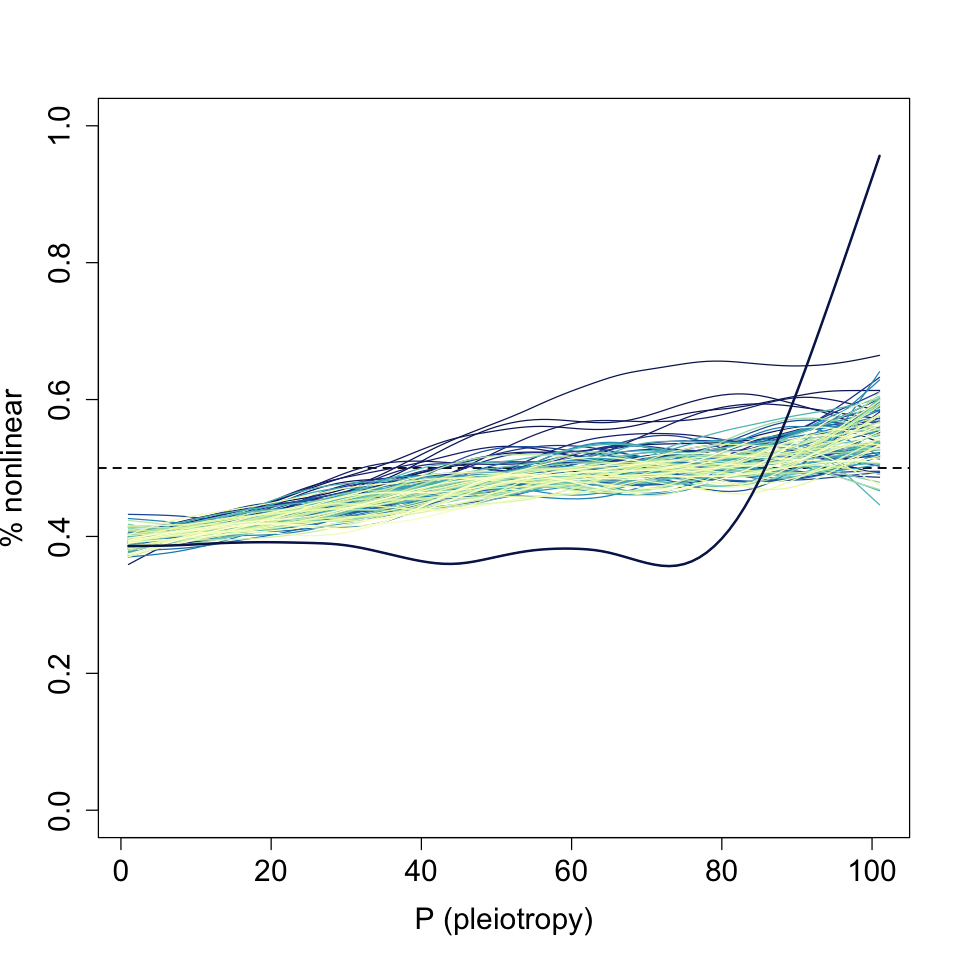

In [13]:
cols <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(length(a_smooth)))
plot(a_smooth[[1]],
  type = "l",
  ylim = c(0, 1),
  col = cols[1],
  ylab = "% nonlinear",
  xlab = "Pleiotropy (probability)",
  cex.axis = 1.5,
  cex.lab = 1.5
)
abline(h = 0.5, lwd = 1.5, lty = "dashed")
for (i in 2:length(a_smooth)) {
  lines(a_smooth[[i]], col = cols[i])
}
lines(a_smooth[[1]], lwd = 2, col = cols[1])

## Compare nonlinearity and entropy across all probabilities

<font size="3"> Calculate subsampled entropy for all probability combinations

In [14]:
full_entropies <- lapply(p, function(x) {
  lapply(x, function(z) {
    subsample.entropy(z,
      numBins = 100,
      permutations = 100,
      normalize_entropy = FALSE,
      sample_sizes = seq(0.1, 0.9, 0.1)
    )
  })
})

<font size="3"> Fit slopes

In [15]:
slopes <- lapply(full_entropies, function(x) {
  lapply(x, function(z) {
    y <- colMeans(do.call(cbind, z$entropies))
    coef(lm(y ~ seq(1, length(y), 1)))[2]
  })
})

<font size="3"> Compare entropy slope and nonlinearity across all probability combinations

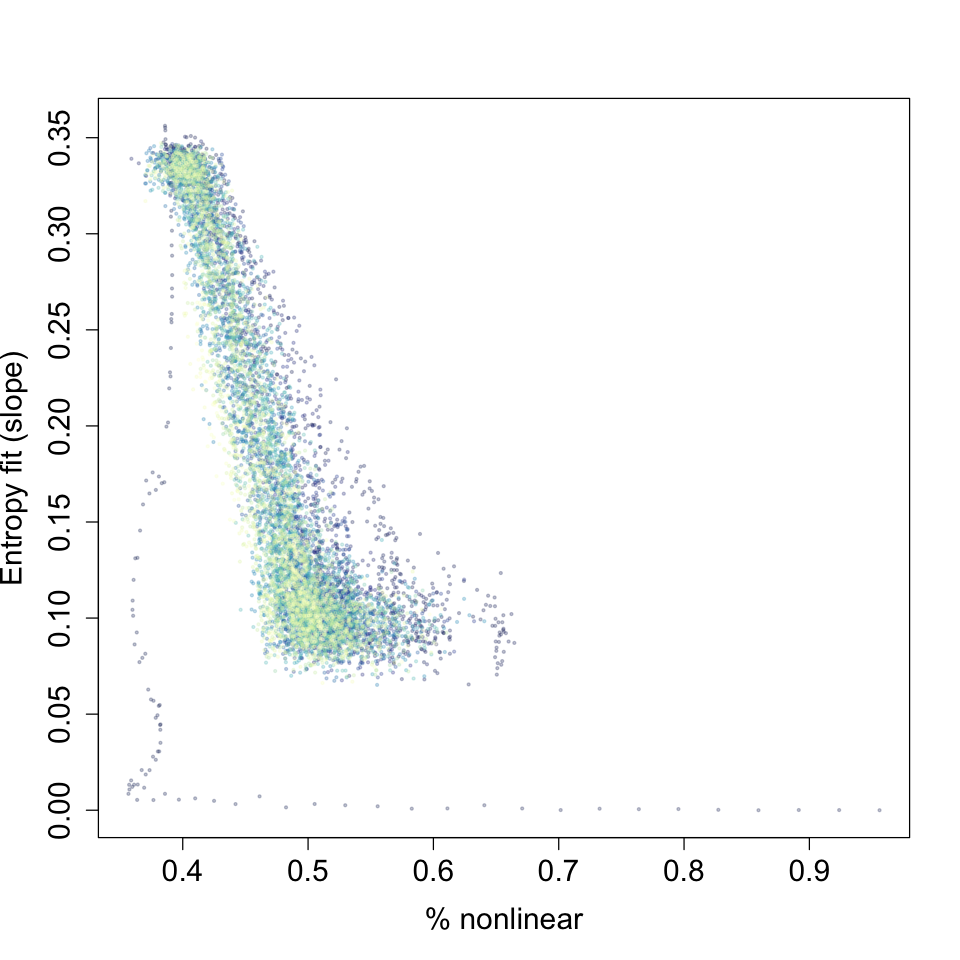

In [16]:
cols <- rev(colorRampPalette(RColorBrewer::brewer.pal(9, "YlGnBu"))(length(unlist(a_smooth))))
plot(unlist(a_smooth),
  unlist(slopes),
  xlab = "% nonlinear",
  ylab = "Entropy fit (slope)",
  cex.lab = 1.5,
  cex.axis = 1.5,
  cex = 0.5,
  pch = 20,
  col = alpha(cols, 0.25)
)